In [1]:
from gbdxtools import CatalogImage, Interface
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from scipy.misc import bytescale
import shapely
from shapely.wkt import loads
import pandas as pd
from fiona.crs import from_epsg

%matplotlib inline

In [2]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

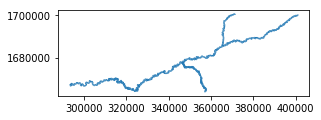

In [3]:
pts_shp = 'sample_pts/sample_pts.shp'
pts = gpd.read_file(pts_shp)


line_shp = 'sample_pts/reach500wNM&counts.shp'
river_df = gpd.read_file(line_shp)

fig, ax = plt.subplots(1, figsize=(4.5,10))
river_df.plot(ax=ax)
# ax.legend(loc='middle')
plt.show()

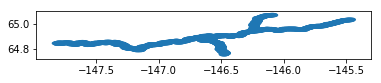

In [4]:
river_buffer = river_df.buffer(2000)
river_df_buffer = river_df.copy()
river_df_buffer['geometry'] = river_buffer

river_df_buffer_wgs84 = river_df_buffer.to_crs(epsg=4326)
river_df_buffer_wgs84.plot()

## search the catalog and view as data frames

In [5]:
river_df_buffer_wgs84.unary_union.wkt

'POLYGON ((-147.5111171936318 64.81730609767567, -147.5113715211986 64.81721485587748, -147.514334185657 64.81624426418333, -147.5144558280993 64.81620795230447, -147.5157589370673 64.8158341847858, -147.5158815779202 64.81580040561855, -147.5188559215401 64.81505293595107, -147.5197753225317 64.81486325298336, -147.5197988542114 64.81485801294519, -147.5204376335254 64.81471870560522, -147.5205188087584 64.81470137247186, -147.5214105582086 64.81452586557091, -147.5219639559876 64.81441168098453, -147.5223938945183 64.81433206368219, -147.5223941166745 64.81433228118001, -147.5229550152332 64.81422188095222, -147.523101694409 64.81419539135258, -147.523551240484 64.81410637037746, -147.5237455564717 64.81407082643335, -147.5245836038883 64.8139007219503, -147.5276596312863 64.81339781417117, -147.5277470679289 64.81338516546707, -147.531691809896 64.81290434337355, -147.5317901948466 64.81289453008881, -147.5346006640256 64.8126568060806, -147.5348302985236 64.81264081654336, -147.539

In [6]:
def flatten_dict(d):
    def expand(key, value):
        if isinstance(value, dict):
            return [ (key + '.' + k, v) for k, v in flatten_dict(value).items() ]
        else:
            return [ (key, value) ]

    items = [ item for k, v in d.items() for item in expand(k, v) ]

    return dict(items)

def flatten_dict_dg(d):
    def expand(key, value):
        if isinstance(value, dict):
            return [ (key + '.' + k, v) for k, v in flatten_dict(value).items() ]
        else:
            return [ (key, value) ]

    items = [ item for k, v in d.items() for item in expand(k, v) ]
    d = dict(items)
    d['properties.item_type'] = d['properties.item_type'][-1]
    
    return d


## search for other image
from shapely.geometry import box

## construct some queries
# query = 'item_type:QB OR item_type:GE01'
# query = 'item_type:GE01'
# query = 'item_type:QB02'
# query = 'item_type:ESAProduct'
query = 'item_type:WV03_VNIR OR item_type:WV02 OR item_type:WV04'
query += 'AND ((item_date:>=2017-06-01) AND (item_date:<2017-08-31))' # for some reason this isn't honored??

pt_dfs = []
gbdx = Interface()

aoi = river_df_buffer_wgs84.unary_union.wkt
recs = gbdx.vectors.query(aoi, query, count=4000) # count keyword default is 100, # results returned
print(len(recs))
# pt_dfs.append(pd.DataFrame([flatten_dict_dg(r) for r in recs]))
river_results = pd.DataFrame([flatten_dict_dg(r) for r in recs])


3529


In [7]:
river_results.head()

,geometry.coordinates,geometry.type,properties.attributes.acquisitionDate,properties.attributes.attFile,properties.attributes.bands,properties.attributes.bandsList,properties.attributes.browseJpgFile,properties.attributes.browseURL,properties.attributes.bucketName,properties.attributes.bucketPrefix,...,properties.ingest_attributes._rest_user,properties.ingest_date,properties.ingest_source,properties.item_date,properties.item_type,properties.name,properties.original_crs,properties.source,properties.text,type
0,"[[[[-148.0647325, 64.93422397], [-147.6491287,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-11T17:48:49.976Z,GBDX_INGEST_ALPHA,2016-11-13T22:08:31.083Z,WV02,None,EPSG:4326,None,,Feature
1,"[[[[-147.9209657, 64.91766205], [-147.515692, ...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-11T18:03:26.774Z,GBDX_INGEST_ALPHA,2015-04-14T21:25:00.837Z,WV02,None,EPSG:4326,None,,Feature
2,"[[[[-147.439762, 64.76489727], [-147.9685289, ...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-12T01:05:59.897Z,GBDX_INGEST_ALPHA,2016-05-14T06:08:27.343Z,WV02,None,EPSG:4326,None,,Feature
3,"[[[[-147.9023842, 64.91882504], [-147.5367904,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-12T01:04:39.370Z,GBDX_INGEST_ALPHA,2016-03-23T21:39:14.320Z,WV02,None,EPSG:4326,None,,Feature
4,"[[[[-148.0826858, 66.01231831000007], [-147.69...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisitionsvc@digitalglobe.com,2018-05-28T00:12:09.671Z,GBDX_INGEST_ALPHA,2018-05-27T21:39:16.000Z,WV02,None,EPSG:4326,None,,Feature


In [9]:
## create month and year columns
yr = [int(d.split('-')[0]) for d in river_results['properties.item_date']]
mo = [int(d.split('-')[1]) for d in river_results['properties.item_date']]
river_results['month'] = mo
river_results['year'] = yr

# create the subdata frames for each sensor
river_results_summer = river_results[river_results.year == 2017] #& ((river_results.month >= 6) & (river_results.month <= 8))]
river_results_summer = river_results_summer[river_results_summer.month >= 6]
river_results_summer = river_results_summer[river_results_summer.month <= 8]
river_results_summer = river_results_summer[river_results_summer['properties.attributes.cloudCover_int'] < 10]
river_results_summer_wv3 = river_results_summer[river_results_summer['properties.item_type'] == 'WV03_VNIR']
river_results_summer_wv2 = river_results_summer[river_results_summer['properties.item_type'] == 'WV02']
river_results_summer_wv1 = river_results_summer[river_results_summer['properties.item_type'] == 'WV01']

print('WV3 scenes: {}'.format(river_results_summer_wv3.shape[0]))
print('WV2 senes: {}'.format(river_results_summer_wv2.shape[0]))
print('WV1 scenes: {}'.format(river_results_summer_wv1.shape[0]))

WV3 scenes: 19
WV2 senes: 70
WV1 scenes: 8


In [19]:
## concat the WV2 and WV3
wv2_3 = gpd.GeoDataFrame( pd.concat( [river_results_summer_wv2, river_results_summer_wv3], ignore_index=True, sort=False) )
wv2_3.crs = from_epsg(4326)

,geometry.coordinates,geometry.type,properties.attributes.acquisitionDate,properties.attributes.attFile,properties.attributes.bands,properties.attributes.bandsList,properties.attributes.browseJpgFile,properties.attributes.browseURL,properties.attributes.bucketName,properties.attributes.bucketPrefix,...,properties.item_date,properties.item_type,properties.name,properties.original_crs,properties.source,properties.text,type,month,year,geometry
0,"[[[[-146.7641437, 64.74285293], [-146.3572845,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,2017-06-22T07:34:17.917Z,WV02,None,EPSG:4326,None,,Feature,6,2017,"POLYGON ((-146.7641437 64.74285293, -146.35728..."
1,"[[[[-148.0655113, 64.91082096000008], [-147.67...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,2017-06-03T07:35:55.000Z,WV02,None,EPSG:4326,None,,Feature,6,2017,"POLYGON ((-148.0655113 64.91082096000008, -147..."
2,"[[[[-147.68577857, 65.16423888], [-147.2936628...",MultiPolygon,2017-06-05T21:38:13.164Z,NaN,NaN,NaN,NaN,NaN,rda-images-1,NaN,...,2017-06-05T21:38:13.164Z,WV02,None,EPSG:4326,None,,Feature,6,2017,"POLYGON ((-147.68577857 65.16423888, -147.2936..."
3,"[[[[-147.77144417, 65.01046172], [-147.3746139...",MultiPolygon,2017-06-13T21:42:45.976Z,NaN,NaN,NaN,NaN,NaN,rda-images-1,NaN,...,2017-06-13T21:42:45.976Z,WV02,None,EPSG:4326,None,,Feature,6,2017,"POLYGON ((-147.77144417 65.01046172, -147.3746..."
4,"[[[[-147.7713557, 64.99172466], [-147.37518443...",MultiPolygon,2017-06-13T21:42:45.799Z,NaN,NaN,NaN,NaN,NaN,rda-images-1,NaN,...,2017-06-13T21:42:45.799Z,WV02,None,EPSG:4326,None,,Feature,6,2017,"POLYGON ((-147.7713557 64.99172466, -147.37518..."


C:\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


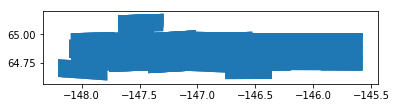

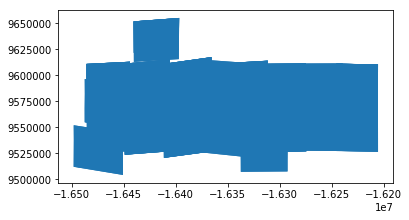

In [23]:
# river_results_summer_wv3.columns.tolist()
# # river_results_summer_wv2['properties.attributes.cloudCover_int']
# river_results_summer_wv2['geometry.coordinates'][182][0][0]

# add geometries as a column for wv2
poly_list = []
for coordinates in river_results_summer_wv2['geometry.coordinates']:
    
    points= [shapely.geometry.Point(p[0], p[1]) for p in coordinates[0][0]]
    coords = sum(map(list, (p.coords for p in points)), [])
    poly = shapely.geometry.Polygon(coords)
    poly_list.append(poly)

river_results_summer_wv2['geometry'] = poly_list
wv2_gdf = gpd.GeoDataFrame(river_results_summer_wv2)

# add geometries as a column for wv3
poly_list = []
for coordinates in river_results_summer_wv3['geometry.coordinates']:
    
    points= [shapely.geometry.Point(p[0], p[1]) for p in coordinates[0][0]]
    coords = sum(map(list, (p.coords for p in points)), [])
    poly = shapely.geometry.Polygon(coords)
    poly_list.append(poly)

river_results_summer_wv3['geometry'] = poly_list
wv3_gdf = gpd.GeoDataFrame(river_results_summer_wv2)

wv2_3 = gpd.GeoDataFrame( pd.concat( [wv2_gdf, wv3_gdf], ignore_index=True, sort=False) )
wv2_3.crs = from_epsg(4326)

wv2_3.plot()
wv2_3.crs = from_epsg(4326)
wv2_3.to_crs(epsg=3857).plot()

In [24]:
# for column in wv2_gdf.rename(columns={col: col.replace('.','_') for col in wv2_gdf.columns}).columns:
#     print(column.dtype)

wv2_3['geometry'].to_file('test_wv2_3.shp')
# wv2_gdf.rename(columns={col: col.replace('.','_') for col in wv2_gdf.columns}).to_file('test_wv2.shp')

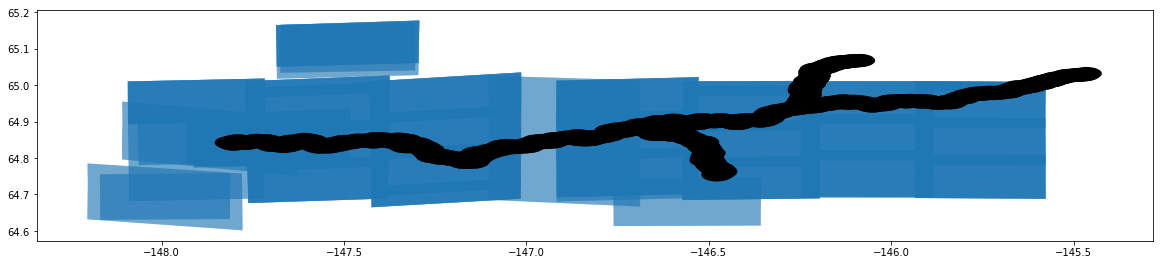

In [25]:
ax = wv2_3.plot(figsize=(20,10), alpha = 0.4)
river_df_buffer_wgs84.plot(ax=ax, color='k')

number of wv2 and wv3 scenes intersecting river extent: 140
number of wv2 and wv3 scenes intersecting river geometry: 96


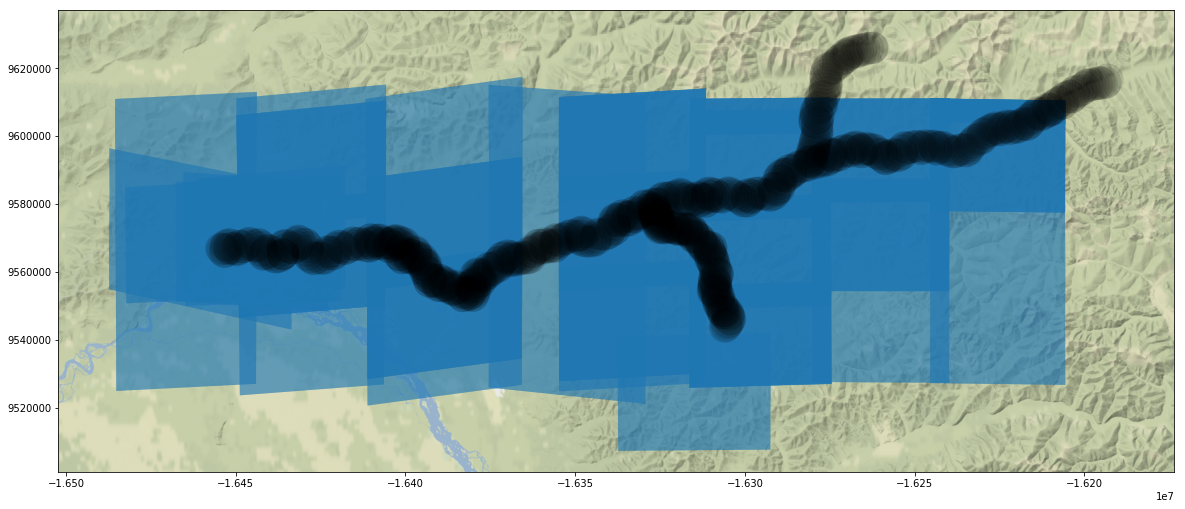

In [31]:
## subset df again by intersection
wv2_3_keep = wv2_3[wv2_3.intersects(river_df_buffer.to_crs(epsg=4326).unary_union)]

print('number of wv2 and wv3 scenes intersecting river extent: {}'.format(wv2_3.shape[0]))
print('number of wv2 and wv3 scenes intersecting river geometry: {}'.format(wv2_3_keep.shape[0]))

plot_crs = 3857
ax = wv2_3_keep[wv2_3_keep['month']==6].to_crs(epsg=3857).plot(figsize=(20,10), alpha = 0.4)
river_df_buffer_wgs84.to_crs(epsg=3857).plot(ax=ax, color='k', alpha = 0.13)
add_basemap(ax, zoom=11)

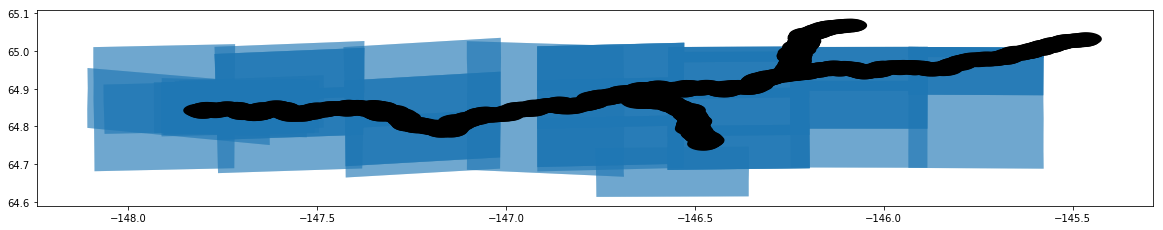

In [27]:
ax = wv2_3_keep.plot(figsize=(20,10), alpha = 0.4)
river_df_buffer_wgs84.plot(ax=ax, color='k')

In [33]:
## get the catalog ids of remaining scenes and check which ones need ordered
wv2_3_ids = wv2_3_keep['properties.attributes.catalogID']
wv2_3_june = wv2_3_keep[wv2_3_keep['month'] == 6]


needs_ordered = []
good_ids = []
for cat_id in wv2_3_june['properties.attributes.catalogID']:
    
    try:
        CatalogImage(cat_id)
        good_ids.append(cat_id)
    except:
        needs_ordered.append(cat_id)
        print('cat_id {} needs ordered'.format(cat_id))
        pass

cat_id 103001006A237800 needs ordered
cat_id 103001006A5AF900 needs ordered
cat_id 103001006AA6C200 needs ordered
cat_id 10300100693F7A00 needs ordered
cat_id 103001006CC24800 needs ordered
cat_id 103001006A323E00 needs ordered
cat_id 103001006D217000 needs ordered
cat_id 103001006B450900 needs ordered
cat_id 1030010069720500 needs ordered
cat_id 103001006A5E8B00 needs ordered
cat_id 103001006A237800 needs ordered
cat_id 103001006A5AF900 needs ordered
cat_id 103001006AA6C200 needs ordered
cat_id 10300100693F7A00 needs ordered
cat_id 103001006CC24800 needs ordered
cat_id 103001006A323E00 needs ordered
cat_id 103001006D217000 needs ordered
cat_id 103001006B450900 needs ordered
cat_id 1030010069720500 needs ordered
cat_id 103001006A5E8B00 needs ordered


In [53]:
del temp

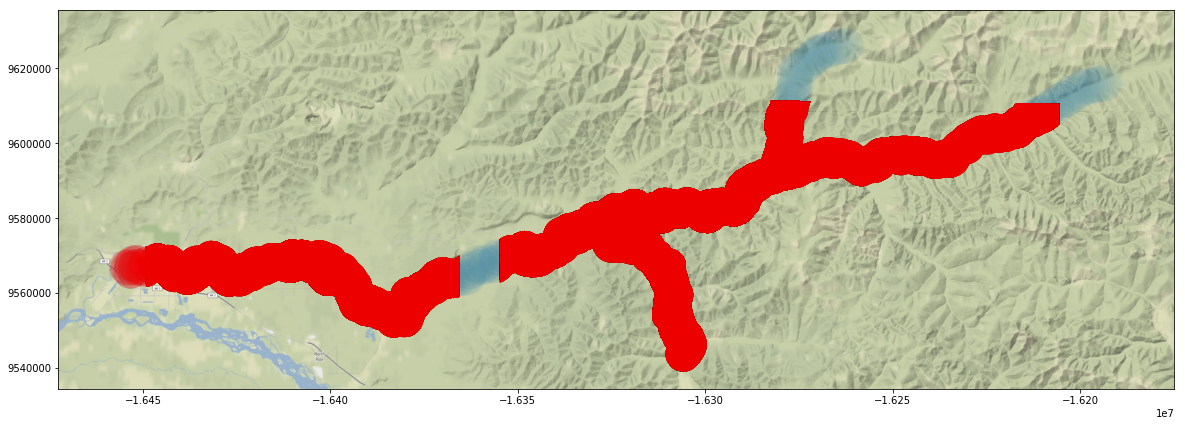

In [34]:
# plot coverage on buffered river corridor
ax = river_df_buffer_wgs84.to_crs(epsg=3857).plot(alpha=0.05, figsize=(20,20))
for cat_id in good_ids:
    # get the row
    cur = wv2_3_june[wv2_3_june['properties.attributes.catalogID'] == cat_id]
        
    temp = gpd.overlay(cur, river_df_buffer_wgs84, how='intersection')
    
    temp.to_crs(epsg=3857).plot(ax=ax, alpha=0.05, color='r')
    
    bbox = temp.unary_union.bounds
    

add_basemap(ax, zoom=11)    
plt.show()

In [36]:
for cat_id in good_ids:
    # get the row
    cur = wv2_3_june[wv2_3_june['properties.attributes.catalogID'] == cat_id]
        
    # clip the buffered river geometry
    #temp = gpd.overlay(river_df_buffer_wgs84, cur, how='intersection')
    temp = gpd.overlay(cur, river_df_buffer_wgs84, how='intersection')
    bbox = temp.unary_union.bounds
    
    # get the image from GBDX
    img = CatalogImage(cat_id, acomp=True)
    aoi = img.aoi(bbox=bbox)
    print('image dims: {}, cropped dims: {}, id: {}'.format(img.shape, aoi.shape, cat_id))
    
#     for i, win in enumerate(aoi.window_cover((256,256), pad=True)):
#         print('saving window {}'.format(i))
#         win.geotiff(path='test_tile_{}.tif'.format(i))
    
    #break

image dims: (8, 18248, 20772), cropped dims: (8, 3046, 20424), id: 103001006B612700
image dims: (8, 17681, 20422), cropped dims: (8, 14952, 20264), id: 1030010069AF8800
image dims: (8, 17251, 19770), cropped dims: (8, 7799, 19723), id: 10300100699C0D00
image dims: (8, 17251, 19770), cropped dims: (8, 7799, 19723), id: 10300100699C0D00
image dims: (8, 18591, 20676), cropped dims: (8, 4434, 20665), id: 10300100690B2700
image dims: (8, 17251, 19770), cropped dims: (8, 7799, 19723), id: 10300100699C0D00
image dims: (8, 18329, 20475), cropped dims: (8, 2578, 7447), id: 103001006B4F3F00
image dims: (8, 17681, 20422), cropped dims: (8, 14952, 20264), id: 1030010069AF8800
image dims: (8, 17251, 19770), cropped dims: (8, 7799, 19723), id: 10300100699C0D00
image dims: (8, 17889, 20173), cropped dims: (8, 4851, 20014), id: 103001006A7BD900
image dims: (8, 18248, 20772), cropped dims: (8, 3046, 20424), id: 103001006B612700
image dims: (8, 17889, 20173), cropped dims: (8, 4851, 20014), id: 10300100

In [47]:
wv2_3_june['geometry']

save_shp = wv2_3_june[['geometry','properties.attributes.catalogID']]
save_shp.rename(columns={col: col.replace('.','_') for col in save_shp.columns}).to_file('test_wv2_3_june.shp')

# wv2_3_june['geometry','properties.attributes.catalogID'].to_file('test_wv2_3_june.shp')
# wv2_gdf.rename(columns={col: col.replace('.','_') for col in wv2_gdf.columns}).to_file('test_wv2.shp')

In [48]:
# check one of the small ones
small_id = '103001006B2FD200'
img_small = CatalogImage(small_id)

# get the row
cur = wv2_3_june[wv2_3_june['properties.attributes.catalogID'] == small_id]

# clip the buffered river geometry
#temp = gpd.overlay(river_df_buffer_wgs84, cur, how='intersection')
temp = gpd.overlay(cur, river_df_buffer_wgs84, how='intersection')
small_bbox = temp.unary_union.bounds

aoi = img_small.aoi(bbox=small_bbox)
aoi.shape

# plt.figure(figsize=(20,20))
# aoi.plot()

(8, 5155, 20308)

In [60]:
## order it via gbdx
# for cat_id in good_ids:
for cat_id in ['103001006B2FD200']:
    # order the image to get the output location
    tasks = []

    # Pre-Image Auto ordering task parameters
    pre_order = gbdx.Task("Auto_Ordering")
    pre_order.inputs.cat_id = cat_id
    pre_order.impersonation_allowed = True
    pre_order.persist = True
    pre_order.timeout = 36000
    #uc_task.inputs.pre_image_dir = pre_order.outputs.s3_location.value
    tasks += [pre_order]
    
    # set up the aop task
    data = pre_order.outputs.s3_location
    aoptask = gbdx.Task('AOP_Strip_Processor', data=data, bands='PAN+MS', enable_pansharpen=True, enable_dra=False)
    tasks += [aoptask]
    
    # save the data
    out_location = 'mcglinchy_yukon_data/forK_PS/{}'.format(cat_id)
#     savedata = gbdx.Task('SaveToS3')
#     savedata.inputs.destination = out_location
#     savedata.inputs.access_key_id = gbdx.s3.info['S3_access_key']
#     savedata.inputs.secret_key = gbdx.s3.info['S3_secret_key']
#     savedata.inputs.session_token = gbdx.s3.info['S3_session_token']
#     savedata.inputs.data = aoptask.outputs.data
#     tasks += [savedata]

    
    wf3 = gbdx.Workflow(tasks)
    wf3.savedata(aoptask.outputs.data, location=out_location)
    wf3.execute()
    
    break
    
#     workflow.savedata(pre_order.outputs.s3_location, location='mcglinchy_yukon_data/{}'.format(bid))

In [75]:
wf3.status
# wf3.events

{'state': 'complete', 'event': 'succeeded'}

In [77]:
wf3.id

'5037656842417820546'

In [30]:
## this should work too, but it doesnt. so filtering the data frame is the way to go..
from gbdxtools import Catalog

query_item = 'item_type:WV03_VNIR OR item_type:WV02 OR item_type:WV04'
query_date_start = 'item_date:>=2017-06-01'
query_date_end = 'item_date:<2017-08-31'
startDate = "2017-06-01T00:00:00.000Z"
endDate = "2017-08-31T00:00:00.000Z"
recs = Catalog.search(aoi, filters=[query_item], startDate=startDate, endDate=endDate)
recs

AttributeError: 'str' object has no attribute 'base_url'

In [9]:
## print out the sensor types for the 3rd point in the geometry set, call it pt0_df

item_type = 'properties.item_type'
pt0_df = pt_dfs[2]
pt0_sensors = pt0_df.groupby(item_type)

print(pt0_sensors)
for name, group in pt0_sensors:
    print('{}: {} available scenes'.format(name, group.shape[0]))

1BProduct: 10 available scenes
GE01: 12 available scenes
QB02: 5 available scenes
SENTINEL2: 250 available scenes
WV02: 21 available scenes
WV03_VNIR: 8 available scenes


In [10]:
## make each item type into a data frame

ls_df = list(pt0_sensors)
df_1B = ls_df[0][1]
df_ge = ls_df[1][1]
df_qb = ls_df[2][1]
df_S2 = ls_df[3][1]
df_wv02 = ls_df[4][1]
df_wv03 = ls_df[5][1]

In [11]:
df_wv02.keys()
df_wv02['properties.attributes.cloudCover_int'][:4],df_wv02['properties.attributes.catalogID'][:4]


(1      0
 16     8
 39    99
 44    99
 Name: properties.attributes.cloudCover_int, dtype: int64,
 1     103001007D0A7D00
 16    103001000A125C00
 39    103001004BD4C000
 44    10300100606A7900
 Name: properties.attributes.catalogID, dtype: object)

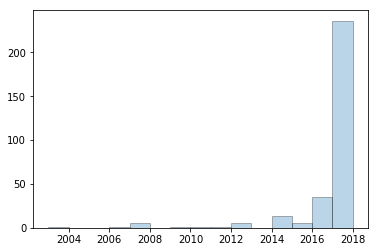

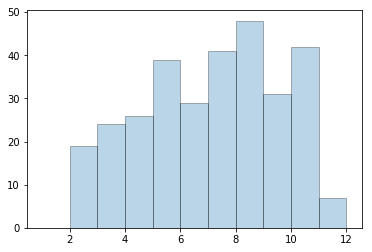

In [15]:
## get the min and max date
years, months = [], []
for entry in pt0_df.iterrows():
    #print(entry[1]['properties.attributes.acquisitionDate'], entry[1]['properties.item_date'])
    item_date = entry[1]['properties.item_date'].split('T')[0].split('-')
    yr = item_date[0]
    mnt = item_date[1]
    day = item_date[2]
    
    years.append(int(yr))
    months.append(int(mnt))
    
plt.figure
plt.hist(years, bins = np.arange(min(years), max(years) + 1), alpha=0.3, edgecolor='k')
plt.show()

plt.figure
plt.hist(months, bins = np.arange(1, 13), alpha=0.3, edgecolor='k')
plt.show()

In [16]:
max_year = max(years)
min_year = min(years)
max_year, min_year

(2018, 2003)

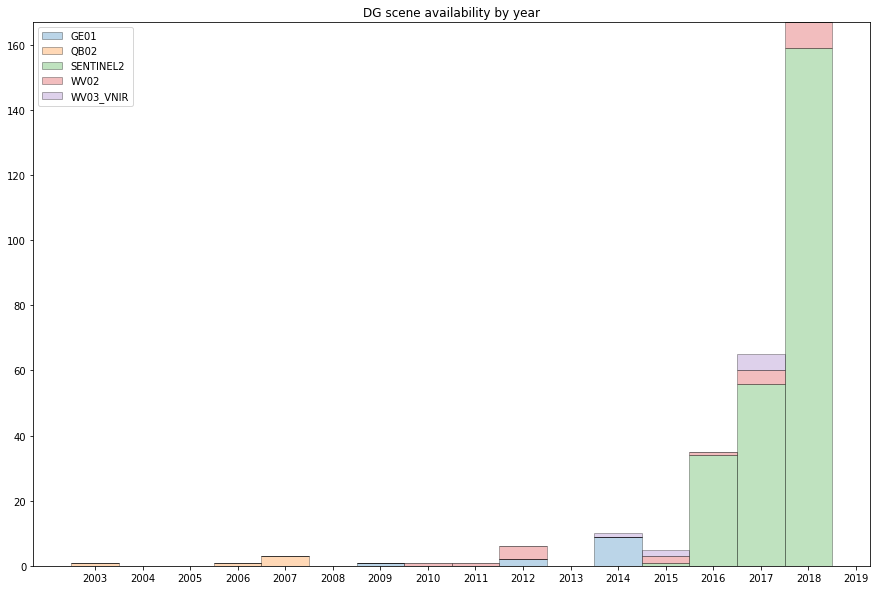

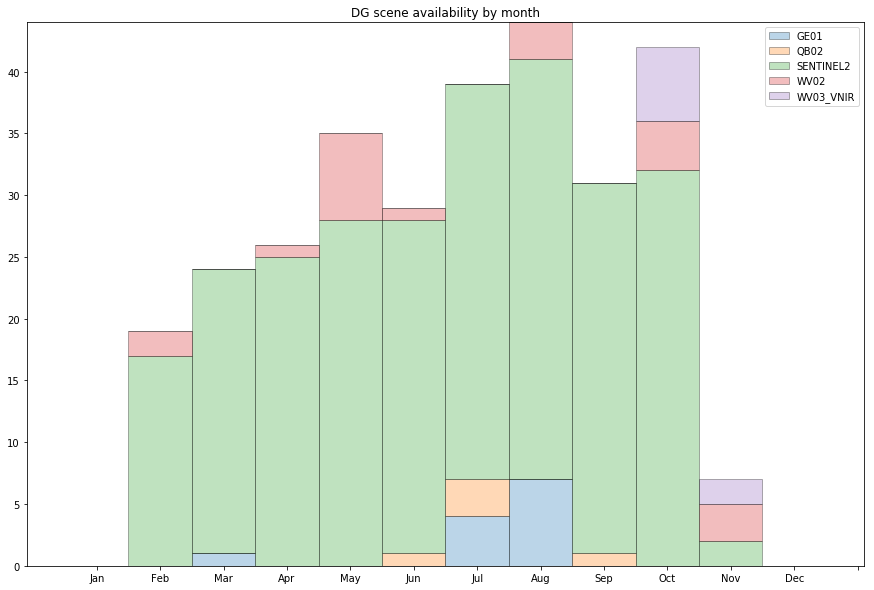

In [18]:
## organize by columns == sensor, stack the histogram

num_sensors = len(pt0_sensors)
num_years = max_year - min_year
yr_bins = np.arange(min_year, max_year+2)

sens_years = np.zeros((num_years, num_sensors))
sens_months = np.zeros((12, num_sensors))

m_bins = np.arange(1,14)

# some lists for bar chart
year_ls, month_ls, labels = [],[], []
for i,group in enumerate(pt0_sensors):
    
    if i==0:
        continue
    
    name, data = group
    labels.append(name)
    
    #print(entry[1]['properties.attributes.acquisitionDate'], entry[1]['properties.item_date'])
    years, months = [], []
    for entry in data.iterrows():
        item_date = entry[1]['properties.item_date'].split('T')[0].split('-')
        yr = item_date[0]
        mnt = item_date[1]
        day = item_date[2]
        
        years.append(int(yr))
        months.append(int(mnt))
        
#     # calculate the histograms
#     y_hist, _ = np.histogram(years, yr_bins)
#     m_hist, _ = np.histogram(months, m_bins)
    
#     # fill out column array
#     sens_years[:,i] = y_hist
#     sens_months[:,i] = m_hist
    
    # append to lists
    year_ls.append(years)
    month_ls.append(months)

fig, ax = plt.subplots(1, figsize=(15,10))
a = ax.hist(year_ls, yr_bins, histtype='bar', stacked=True, alpha=0.3, edgecolor='k', label=labels, align='left')
plt.legend()
ax.set_title('DG scene availability by year')
ax.set_xticks(yr_bins)
plt.show()

fig, ax = plt.subplots(1, figsize=(15,10))
b = ax.hist(month_ls, m_bins, histtype='bar', stacked=True, alpha=0.3, edgecolor='k', label=labels, align='left')
plt.legend()
ax.set_title('DG scene availability by month')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
ax.set_xticks(m_bins)
plt.show()

# p1 = ax.bar(yr_bins, sens_years[:,0])
# for i in range(1, num_sensors):
    

#     plt.bar(yr_bins, sens_years[:,i], bottom=sens_years[:,i-1])
    
# plt.show()


In [19]:
pt0_df

,geometry.coordinates,geometry.type,properties.attributes.acquisitionDate,properties.attributes.attFile,properties.attributes.bands,properties.attributes.bandsList,properties.attributes.browseJpgFile,properties.attributes.browseURL,properties.attributes.bucketName,properties.attributes.bucketPrefix,...,properties.ingest_attributes._rest_user,properties.ingest_date,properties.ingest_source,properties.item_date,properties.item_type,properties.name,properties.original_crs,properties.source,properties.text,type
0,"[[[[-146.5634307, 66.80536507], [-146.1498264,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-11T20:23:47.086Z,GBDX_INGEST_ALPHA,2015-11-18T22:07:39.485Z,WV03_VNIR,None,EPSG:4326,None,,Feature
1,"[[[[-146.52407412, 66.52994681], [-146.0913827...",MultiPolygon,2018-05-22T21:22:59.727Z,NaN,NaN,NaN,NaN,NaN,rda-images-1,NaN,...,idahosvc@digitalglobe.com,2018-07-20T00:31:10.001Z,GBDX_INGEST_ALPHA,2018-05-22T21:22:59.727Z,WV02,None,EPSG:4326,None,,Feature
2,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/3/4/0,...,sentinelsvc@digitalglobe.com,2018-10-03T01:32:11.419Z,GBDX_INGEST_ALPHA,2018-03-04T21:35:31.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
3,"[[[[-146.1363201, 66.65063882], [-145.9795154,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-12T00:24:57.226Z,GBDX_INGEST_ALPHA,2006-09-24T21:35:48.714Z,QB02,None,EPSG:4326,None,,Feature
4,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/3/11/0,...,sentinelsvc@digitalglobe.com,2018-10-03T00:51:38.169Z,GBDX_INGEST_ALPHA,2018-03-11T21:25:21.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
5,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/3/31/0,...,sentinelsvc@digitalglobe.com,2018-10-03T01:07:47.172Z,GBDX_INGEST_ALPHA,2018-03-31T21:25:21.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
6,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/4/20/0,...,sentinelsvc@digitalglobe.com,2018-10-04T05:13:43.707Z,GBDX_INGEST_ALPHA,2018-04-20T21:25:21.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
7,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/9/3/0,...,sentinelsvc@digitalglobe.com,2018-10-03T20:56:16.005Z,GBDX_INGEST_ALPHA,2018-09-03T21:45:31.024Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
8,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/5/30/0,...,sentinelsvc@digitalglobe.com,2018-10-03T04:51:10.324Z,GBDX_INGEST_ALPHA,2018-05-30T21:25:21.024Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
9,"[[[[-146.439062, 66.75334338], [-146.0434548, ...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-12T02:21:15.128Z,GBDX_INGEST_ALPHA,2003-06-23T21:17:16.607Z,QB02,None,EPSG:4326,None,,Feature


In [20]:
## show the CatalogIDs of the WorldView-2 images
df_wv02['properties.attributes.catalogID']

1      103001007D0A7D00
16     103001000A125C00
39     103001004BD4C000
44     10300100606A7900
51     103001007F46C300
52     1030010004484300
57     103001007D0A7D00
61     103001007D0A7D00
68     103001004E44B200
69     103001007D0A7D00
70     103001007D0A7D00
71     103001007885A400
72     1030010079A55E00
115    103001001AA01200
116    10300100731B9400
154    1030010074BB8A00
155    1030010072853700
191    1030010072755A00
248    1030010019B8C900
263    103001001AB5F300
268    103001001B089200
Name: properties.attributes.catalogID, dtype: object

In [23]:
## store the CatalogIDs if cloud cover is less than some number (cc_thresh)
cc_thresh=20
cat_ids = []
for data_fr in (df_qb, df_wv02, df_wv03):
    
    temp_df = data_fr.loc[data_fr['properties.attributes.cloudCover_int'] < cc_thresh]
    cat_ids.extend(list(temp_df['properties.attributes.catalogID'].values))

In [25]:
cat_ids

['101001000538BA00',
 '1010010005BA1800',
 '1010010005BA1800',
 '1010010005BA1800',
 '103001007D0A7D00',
 '103001000A125C00',
 '103001007D0A7D00',
 '103001007D0A7D00',
 '103001007D0A7D00',
 '103001007D0A7D00',
 '103001007885A400',
 '1030010079A55E00',
 '103001001AB5F300',
 '103001001B089200',
 '104001001354BC00',
 '104001001324C900',
 '104001000230AB00']

In [26]:
## cat_ids_to_order holds CatalogIDs to use. Try to see if it is available by calling CatalogImage, 
## and if not, add it to a list to order it.
bbox = pts['geometry'][0].buffer(0.003).bounds
ids_to_order = []
for cid in cat_ids:

    try:
        test=CatalogImage(cid)
        print(test.aoi(bbox=bbox).shape, cid, type(test))
    except Exception as e:
        print(e, cid)
        ids_to_order.append(cid)
        

Could not find a catalog entry for the given id: 101001000538BA00 101001000538BA00
 1010010005BA1800
 1010010005BA1800
 1010010005BA1800
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
Could not find a catalog entry for the given id: 103001000A125C00 103001000A125C00
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
Could not find a catalog entry for the given id: 103001007885A400 103001007885A400
Could not find a catalog entry for the given id: 1030010079A55E00 1030010079A55E00
Could not find a catalog entry for the given id: 103001001AB5F300 103001001AB5F300
Could not find a catalog entry for the given id: 103001001B089200 103001001B089200
Could not find a catalog entry for the given id: 104001001354BC00 1040010

In [27]:
ids_to_order, cat_ids

(['101001000538BA00',
  '1010010005BA1800',
  '1010010005BA1800',
  '1010010005BA1800',
  '103001000A125C00',
  '103001007885A400',
  '1030010079A55E00',
  '103001001AB5F300',
  '103001001B089200',
  '104001001354BC00',
  '104001001324C900',
  '104001000230AB00'],
 ['101001000538BA00',
  '1010010005BA1800',
  '1010010005BA1800',
  '1010010005BA1800',
  '103001007D0A7D00',
  '103001000A125C00',
  '103001007D0A7D00',
  '103001007D0A7D00',
  '103001007D0A7D00',
  '103001007D0A7D00',
  '103001007885A400',
  '1030010079A55E00',
  '103001001AB5F300',
  '103001001B089200',
  '104001001354BC00',
  '104001001324C900',
  '104001000230AB00'])

In [67]:
## fire off GDBX workflow to order each image which needs it
## onces the workflows are done processing, the images can be accessed via CatalogImage

order_flag = True
if order_flag:
    bad_id_wfs = []
    gbdx = Interface()
    for bid in cat_ids_to_order:
       
        tasks = []

        # Pre-Image Auto ordering task parameters
        pre_order = gbdx.Task("Auto_Ordering")
        pre_order.inputs.cat_id = bid
        pre_order.impersonation_allowed = True
        pre_order.persist = True
        pre_order.timeout = 36000
        #uc_task.inputs.pre_image_dir = pre_order.outputs.s3_location.value
        tasks += [pre_order]

        # Set up workflow save data
        workflow = gbdx.Workflow(tasks)
        workflow.savedata(pre_order.outputs.s3_location, location='mcglinchy_yukon_data/{}'.format(bid))

        # Execute workflow
        workflow.execute()

        # append to list
        bad_id_wfs.append(workflow)

In [70]:
## check the status for each workflow (order)

for i,wf in enumerate(bad_id_wfs):
    print('workflow id {}, {} of {}'.format(wf.id, i+1, len(bad_id_wfs)))
    print('status: {}'.format(wf.status))
    print('')
           

workflow id 4944132640958835518, 1 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132643153150290, 2 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132645391142718, 3 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132647571587963, 4 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132649755404023, 5 of 21
status: {u'state': u'pending', u'event': u'waiting'}

workflow id 4944132652428630995, 6 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132654638746147, 7 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132659220023547, 8 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132661757720788, 9 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132664132341542, 10 of 21
status: {u'state': u'pending', u'event': u'waiting'}

workflow id 4944132666442